In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

# Análise nos dados de diárias 2015 dezembro
Rotulando adequadamente o nome das colunas e os tipos de cada uma.

In [5]:
columns_name = ['cargo_servidor',
                'data_partida', 
                'data_retorno', 
                'destino_viagem', 
                'nome_servidor', 
                'sigla_orgao',
                'nomes', 
                'valor_total',
                'motivo_viagem'
               ]

dtypes = {'cargo_servidor': 'str', 
          'data_partida': 'str', 
          'data_retorno': 'str', 
          'destino_viagem': 'str', 
          'nome_servidor': 'str',
          'sigla_orgao': 'str',
          'nomes': 'str', 
          'valor_total': 'float', 
          'motivo_viagem': 'str', 
         }

data = pd.read_csv('data/Diarias_201512.csv', 
                   sep=';',
                   names=columns_name,
                   skiprows=1, 
                   dtype=dtypes
                  )

In [3]:
# Normalizanod datas: 
data['data_partida'] = data['data_partida'].apply(lambda x : x[0:10])
data['data_retorno'] = data['data_retorno'].apply(lambda x : x[0:10])

In [4]:
data.head(2)

,cargo_servidor,data_partida,data_retorno,destino_viagem,nome_servidor,sigla_orgao,nomes,valor_total,motivo_viagem
0,(SERVIDOR MILITAR),2015-12-18,2015-12-21,RIO VERDE,AURELIA MARQUES DE SOUZA,DETRAN,201512,560,NaN
1,(SERVIDOR MOTORISTA),2015-12-30,2015-12-31,PIRENOPOLIS,GUSTAVO DE PAULA PEREIRA PERILO,DETRAN,201512,240,NaN


In [5]:
data['destino_viagem'].drop_duplicates().count()

1119

Os servidores viajaram para 1119 destinos diferentes nesse período.

In [6]:
daily_caldas = data[ data['destino_viagem'].str.contains('CALDAS')]
daily_caldas['cargo_servidor'].drop_duplicates()

2                                        (SERVIDOR CIVIL)
32                                              MOTORISTA
83                                    ASSESSOR ESPECIAL B
124     ASSISTENTE DE TRANSPORTES E OBRAS - 90%- PCR- ...
170                                    (SERVIDOR MILITAR)
215                                           CONSELHEIRO
226                                 ASSESSOR ESPECIAL ¿A¿
266                                                   NaN
352                                  (SERVIDOR MOTORISTA)
507                                           ASSESSOR II
515                            ASSISTENTE DE GABINETE ¿E¿
584                                            ASSISTENTE
646     ASSISTENTE DE TRANSPORTES E OBRAS - PCR-EST- 1...
753                                  ASSISTENTE DE GESTÃO
842                                       PERITO CRIMINAL
1036                    TEC DE NIVEL SUPERIOR MANDADO SEG
1244                                   MEDICO-VETERINARIO
1403          

Filtrando a cidade turística Caldas Novas e isolando os cargos que mais viajaram para lá.

In [7]:
data['valor_total'].sum()

1253566.5899999999

 Gastos com diárias em 2015, dezembro foi de **R$ 1.253.566** milhão

In [8]:
def get_gap_days(row): 
    start_date = datetime.strptime(row['data_partida'], "%Y-%m-%d")
    end_date = datetime.strptime(row['data_retorno'], "%Y-%m-%d")
    
    data_diff = end_date - start_date
    
    return data_diff.total_seconds() / (60 * 60 * 24)

data['estadia_dias'] = data.apply(lambda row: get_gap_days(row), axis=1)
data.head(1)

,cargo_servidor,data_partida,data_retorno,destino_viagem,nome_servidor,sigla_orgao,nomes,valor_total,motivo_viagem,estadia_dias
0,(SERVIDOR MILITAR),2015-12-18,2015-12-21,RIO VERDE,AURELIA MARQUES DE SOUZA,DETRAN,201512,560,NaN,3


Recuperando os dias de deslocamento do servidor

In [9]:
def calc_value_per_day(row): 
    return row['valor_total'] if row['estadia_dias'] <= 0 else float(row['valor_total']) / int(row['estadia_dias'])

data['valor_diario'] = data.apply(lambda row: calc_value_per_day(row), axis=1)

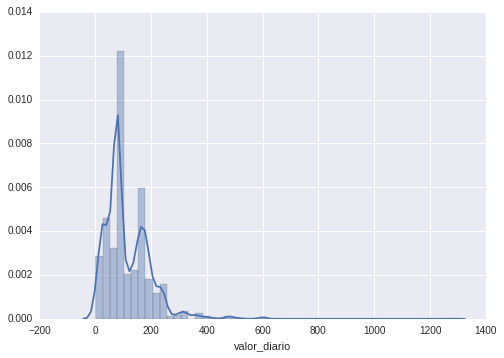

In [10]:
sns.distplot(data['valor_diario'])
None

In [11]:
std_total_value = data['valor_diario'].describe()['std']
mean_total_value = data['valor_diario'].describe()['mean']

print("Desvio padrão R$ {std} Média dos valores R$ {mean}".format(std=std_total_value, mean=mean_total_value))

Desvio padrão R$ 82.0391349971 Média dos valores R$ 114.256827706


In [12]:
records_exceeds_std = data[ data['valor_diario'] > std_total_value]
records_exceeds_mean = data[data['valor_diario'] > mean_total_value]

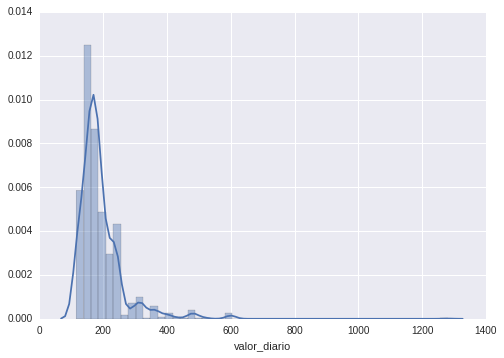

In [13]:
sns.distplot(records_exceeds_mean['valor_diario'])
None

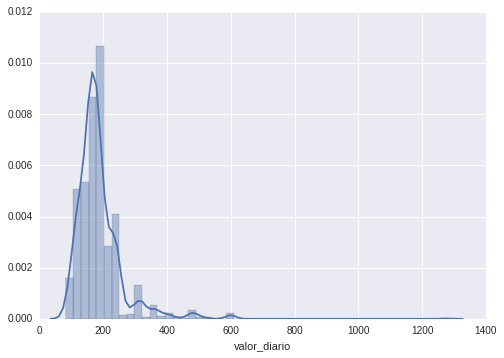

In [14]:
sns.distplot(records_exceeds_std['valor_diario'])
None

In [15]:
std_complement = len(data) - len(records_exceeds_std)
mean_complement = len(data) - len(records_exceeds_mean)
print("Valores que excedem o desvio padrão {std} e {std_com} não. \nValores que excedem a média {mean} e {mean_com} não.".\
      format(std=len(records_exceeds_std),\
             mean=len(records_exceeds_mean),\
             std_com=std_complement,\
             mean_com=mean_complement))

Valores que excedem o desvio padrão 2327 e 3085 não. 
Valores que excedem a média 2206 e 3206 não.


Teoricamente os valores que excedem a média e o desvio padrão podem representar uma anomalia. Deste modo cabe analisar esses casos com mais detalhe.

In [16]:
records_exceeds_std_sorted = records_exceeds_std.sort_values(by='valor_diario', ascending=False)
records_exceeds_std_sorted.iloc[0]

cargo_servidor          ASSESSOR DA DIRETORIA TECNICA - ASSESSOR IV
data_partida                                             2015-12-17
data_retorno                                             2015-12-17
destino_viagem                                       SÃO PAULO - GO
nome_servidor                               LEANDRO KAZUAKI TSURUDA
sigla_orgao                                                  AGEHAB
nomes                                                        201512
valor_total                                                    1280
motivo_viagem     CURSO DE INSTALADOR A INTEGRADOR SOLAR FOTOVOL...
estadia_dias                                                      0
valor_diario                                                   1280
Name: 3618, dtype: object

O registro acima representa o maior gasto registrado no período 2015 mês 12. O servidor permaneceu 0 dias, ou seja, algumas horas, e exigiu R$ 1280 na diária. 

In [17]:
records_exceeds_std_sorted.iloc[2]

cargo_servidor                  1º SGT QPPM
data_partida                     2015-12-09
data_retorno                     2015-12-10
destino_viagem              CASSILÂNDIA-MS.
nome_servidor     JEFERSON MENDES DE AQUINO
sigla_orgao                             SSP
nomes                                201512
valor_total                             600
motivo_viagem                 NÃO INFORMADO
estadia_dias                              1
valor_diario                            600
Name: 4857, dtype: object

In [18]:
# limpando NaNs 
records_exceeds_std_sorted = records_exceeds_std_sorted.fillna('NÃO INFORMADO')

suspects_records_without_motive = \
records_exceeds_std_sorted[records_exceeds_std_sorted['motivo_viagem'].str.contains('NÃO')]


Relação de diárias sem 'motivo da viagem' descriminado no registro. 

In [19]:
suspects_records_without_motive.iloc[0]

cargo_servidor    SECRETÁRIO DA SEGURANÇA PÚBLIC
data_partida                          2015-12-02
data_retorno                          2015-12-03
destino_viagem                    BRASILIA - DF.
nome_servidor          JOAQUIM CLAUDIO FIGUEIRED
sigla_orgao                                  SSP
nomes                                     201512
valor_total                                  600
motivo_viagem                      NÃO INFORMADO
estadia_dias                                   1
valor_diario                                 600
Name: 1083, dtype: object

In [20]:
sum_suspects = suspects_records_without_motive['valor_total'].sum()
len_suspects = len(suspects_records_without_motive)

print(sum_suspects, len_suspects)

(215980.0, 491)


Ou seja, há ao menos 491 registros que não seguem o desvio padrão dos pedidos de diárias e não informam o motivo do deslocamento. Tais registros contabilizam R$ **214.980** mil reais.